In [30]:
import os
import re
from collections import Counter

import pandas as pd
import scanpy as sc
import seaborn as sns

In [31]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%autoreload 2

In [33]:
import pollock

In [34]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [6]:
run_name = 'HTAN_breast_v8'
adata = sc.read_h5ad('/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad')

malignant_cell_type = 'BR_Malignant'
cell_type_key = 'cell_type'
model_save_dir = os.path.join(MODEL_DIR, run_name)

In [38]:
run_name = 'pdac_caf_states_v1'
adata = sc.read_h5ad('/data/single_cell_classification/tumor/PDAC/pdac_caf_subtypes.h5ad')

cell_type_key = 'fibroblast_subtype'
model_save_dir = os.path.join(MODEL_DIR, run_name)

In [39]:
adata

AnnData object with n_obs × n_vars = 38502 × 25282
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'fibroblast_subtype', 'ident', 'sample_id'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [40]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('iCAF', 28907),
 ('myCAF', 6826),
 ('CXCL4+_iCAF', 1294),
 ('apCAF', 1073),
 ('CD133+_iCAF', 402)]

In [41]:
pds = pollock.PollockDataset(adata.copy(), cell_type_key=cell_type_key, n_per_cell_type=500, batch_size=128,
                    dataset_type='training', min_genes=10, min_cells=3, mito_threshold=None,
                    max_n_genes=None, log=True, cpm=False, min_disp=None)

2020-05-26 21:00:17,270 normalizing counts for model training
2020-05-26 21:00:17,271 filtering by min genes: 10
2020-05-26 21:00:19,545 genes remaining after filter: 25282
2020-05-26 21:00:19,547 filtering by min cells: 3
2020-05-26 21:00:23,104 cells remaining after filter: 38502
2020-05-26 21:00:23,105 loging data
2020-05-26 21:00:24,480 scaling data
2020-05-26 21:00:31,596 creating tf datasets


In [42]:
pm = pollock.PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005)

In [43]:
pm.fit(pds, epochs=40)

2020-05-26 21:00:59,551 epoch: 1, train loss: 164.3296661376953, val loss: 169.496337890625
2020-05-26 21:01:03,062 epoch: 2, train loss: 141.0850067138672, val loss: 152.15850830078125
2020-05-26 21:01:06,585 epoch: 3, train loss: 138.1386260986328, val loss: 149.09620666503906
2020-05-26 21:01:10,504 epoch: 4, train loss: 138.28530883789062, val loss: 148.37777709960938
2020-05-26 21:01:14,099 epoch: 5, train loss: 136.21861267089844, val loss: 146.9687957763672
2020-05-26 21:01:18,042 epoch: 6, train loss: 134.3399658203125, val loss: 145.6778564453125
2020-05-26 21:01:21,650 epoch: 7, train loss: 134.03492736816406, val loss: 145.41018676757812
2020-05-26 21:01:25,362 epoch: 8, train loss: 133.1985321044922, val loss: 144.45376586914062
2020-05-26 21:01:28,999 epoch: 9, train loss: 131.563720703125, val loss: 143.2472686767578
2020-05-26 21:01:32,626 epoch: 10, train loss: 130.5226593017578, val loss: 141.98056030273438
2020-05-26 21:01:36,270 epoch: 11, train loss: 130.28482055664

In [44]:
pm.save(pds, model_save_dir)

/miniconda/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


0.9297144910312042


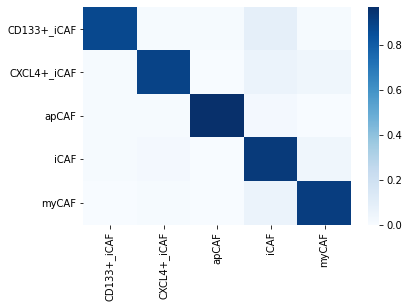

In [46]:
cdf = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
print(pm.summary['validation']['metrics']['accuracy'])
sns.heatmap(cdf, cmap='Blues')

In [47]:
l_pds, l_pm = pollock.load_from_directory(adata, model_save_dir)

2020-05-26 21:05:13,866 normalizing counts for prediction
2020-05-26 21:05:13,867 filtering for genes in training set
2020-05-26 21:05:13,881 0 genes in training set are missing from prediction set
2020-05-26 21:05:18,082 filtering by min genes: 200
Trying to set attribute `.obs` of view, copying.
2020-05-26 21:05:21,472 genes remaining after filter: 25250
2020-05-26 21:05:21,473 loging data
2020-05-26 21:05:22,852 scaling data


In [48]:
labels, label_prob, all_probs = l_pm.predict_pollock_dataset(l_pds, labels=True, )

In [49]:
X_umap = l_pm.get_umap_cell_embeddings(l_pds.prediction_ds)
X_umap

array([[11.306362  ,  7.624285  ],
       [10.986545  ,  8.055782  ],
       [ 3.6320693 , -0.29268736],
       ...,
       [ 5.321761  ,  6.7974415 ],
       [ 9.128813  , -0.5378673 ],
       [ 2.8979788 ,  2.2739646 ]], dtype=float32)

In [50]:
adata.obsm['X_umap'] = X_umap
adata.obs['predicted_cell_type'] = labels

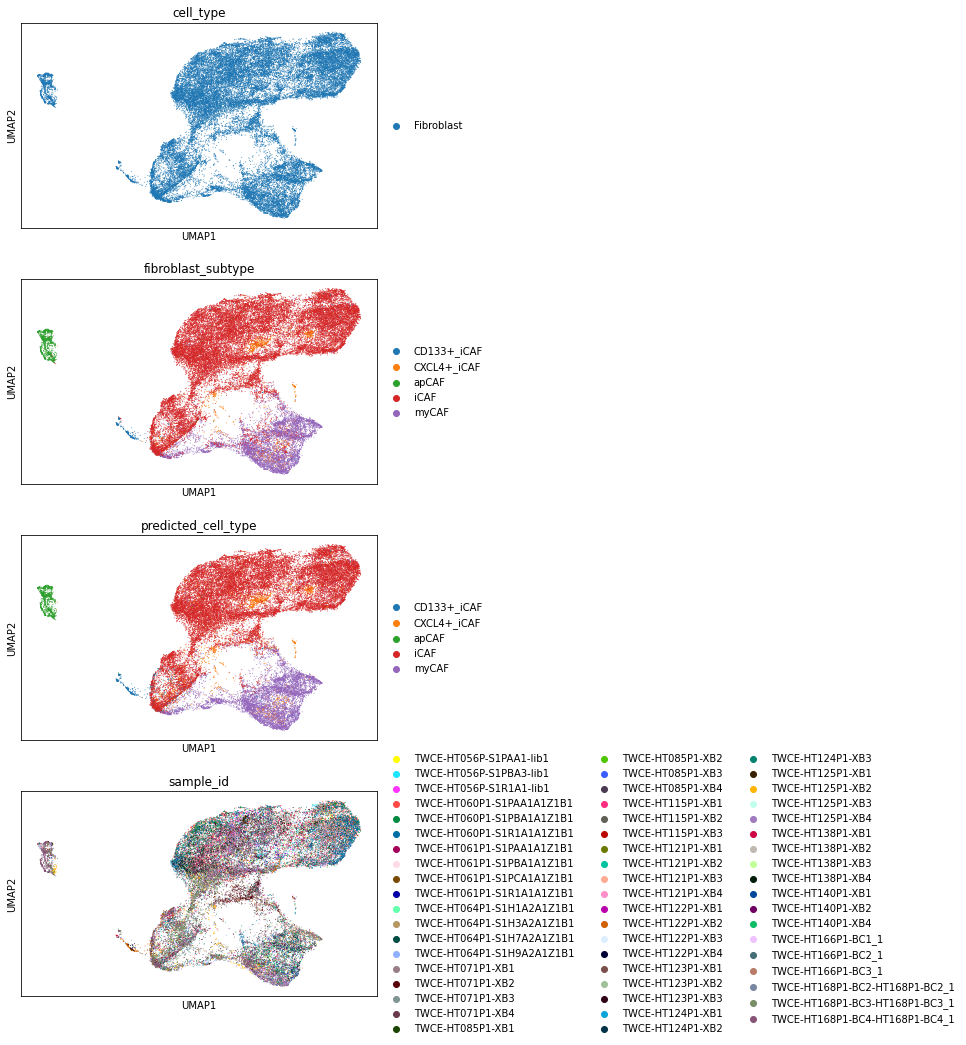

In [52]:
sc.pl.umap(adata, color=['cell_type', cell_type_key, 'predicted_cell_type', 'sample_id'], ncols=1)

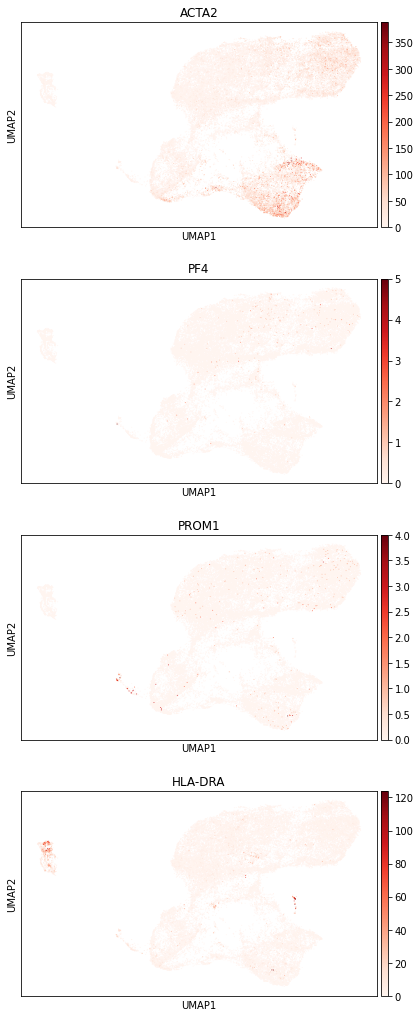

In [60]:
sc.pl.umap(adata, color=['ACTA2', 'PF4', 'PROM1', 'HLA-DRA'], ncols=1, color_map='Reds',)

In [53]:
pdac_adata = sc.read_h5ad('/data/single_cell_classification/tumor/PDAC/pdac.h5ad')
l_pds, l_pm = pollock.load_from_directory(pdac_adata, model_save_dir)
pdac_adata = pdac_adata[l_pds.prediction_adata.obs.index]
labels, label_prob, all_probs = l_pm.predict_pollock_dataset(l_pds, labels=True, )
X_umap = l_pm.get_umap_cell_embeddings(l_pds.prediction_ds)
pdac_adata.obsm['X_umap'] = X_umap
pdac_adata.obs['predicted_cell_type'] = labels

2020-05-26 21:11:12,178 normalizing counts for prediction
2020-05-26 21:11:12,179 filtering for genes in training set
2020-05-26 21:11:12,191 206 genes in training set are missing from prediction set
2020-05-26 21:11:16,600 filtering by min genes: 200
Trying to set attribute `.obs` of view, copying.
2020-05-26 21:11:20,389 genes remaining after filter: 25250
2020-05-26 21:11:20,390 loging data
2020-05-26 21:11:21,832 scaling data


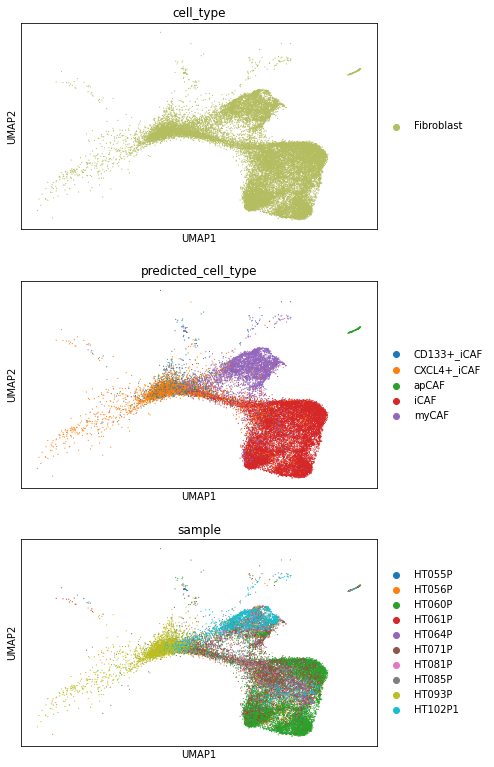

In [55]:
sc.pl.umap(pdac_adata[pdac_adata.obs['cell_type']=='Fibroblast'],
           color=['cell_type', 'predicted_cell_type', 'sample'], ncols=1)

In [61]:
ccrcc_adata = sc.read_h5ad('/data/single_cell_classification/tumor/CCRCC/yige/adata.h5ad')
l_pds, l_pm = pollock.load_from_directory(ccrcc_adata, model_save_dir)
ccrcc_adata = ccrcc_adata[l_pds.prediction_adata.obs.index]
labels, label_prob, all_probs = l_pm.predict_pollock_dataset(l_pds, labels=True, )
X_umap = l_pm.get_umap_cell_embeddings(l_pds.prediction_ds)
ccrcc_adata.obsm['X_umap'] = X_umap
ccrcc_adata.obs['predicted_cell_type'] = labels

2020-05-26 21:20:16,791 normalizing counts for prediction
2020-05-26 21:20:16,792 filtering for genes in training set
2020-05-26 21:20:16,805 369 genes in training set are missing from prediction set
2020-05-26 21:20:37,969 filtering by min genes: 200
Trying to set attribute `.obs` of view, copying.
2020-05-26 21:21:48,774 genes remaining after filter: 25250
2020-05-26 21:21:48,775 loging data
2020-05-26 21:22:10,111 scaling data


/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_cell_type' as categorical


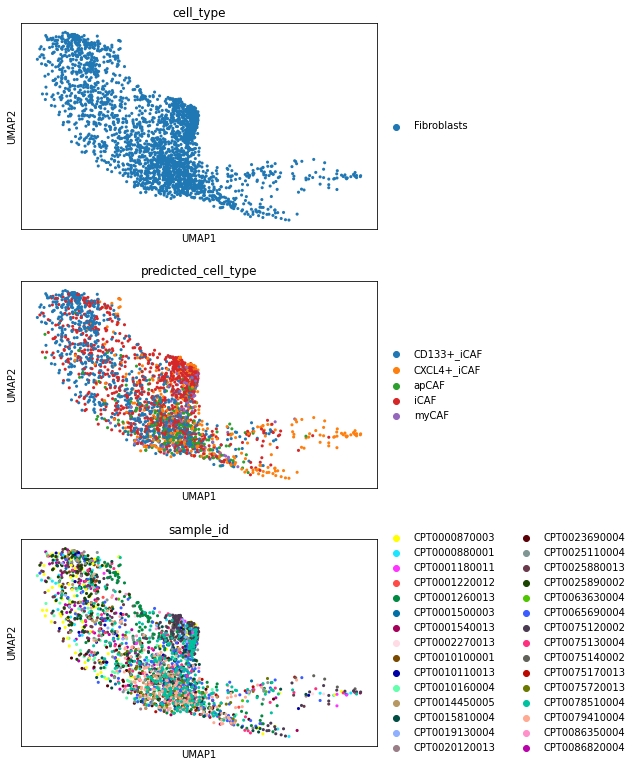

In [62]:
sc.pl.umap(ccrcc_adata[ccrcc_adata.obs['cell_type']=='Fibroblasts'],
           color=['cell_type', 'predicted_cell_type', 'sample_id'], ncols=1)

... storing 'predicted_cell_type' as categorical


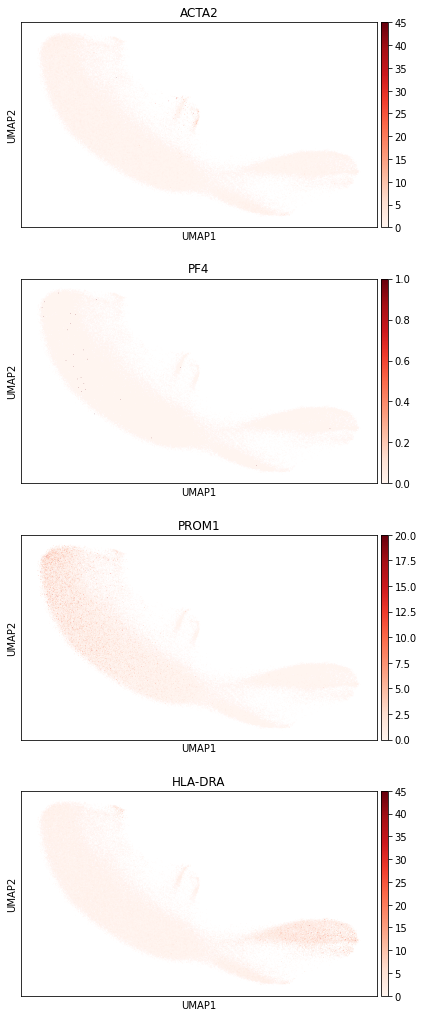

In [63]:
sc.pl.umap(ccrcc_adata, color=['ACTA2', 'PF4', 'PROM1', 'HLA-DRA'], ncols=1, color_map='Reds',)

In [28]:
pm.summary['validation']['metrics']['accuracy']

0.8272731494380979